# COGS 118A - Final Project

# Predicting California Housing Prices

## Group Members

- Sreetama Chowdhury
- Lucy Lenneman
- Prabhjyot Sodhi
- Sukhman Virk

# Abstract 
The goal of this project is to use a set of factors about the houses in a neighborhood to predict median house value within that neighborhood. We intend for this to be a regression task, with the data we use containing such variables as latitude/longitude, the population of a block of houses, the number of households within a block, and more. We plan to conduct model selection across several different model types (linear regression, elasticNet regression, kNN, random forest, decision trees) so as to optimize for minimum error, after which we will test the final and best model and see how accurately it can predict pricing. Accuracy will be measured via metrics like r2, mean squared error, and RMSE.

After running cross validation to find the best hyperparams for the various models, we ran the models with the selected hyperparameters. After running the models and observing the respective error rates, we noticed that the Random Forest model performs the best.

# Background

The prediction of house prices in a certain area is a well researched topic in the field of Machine Learning. There have been several instances of research conducted to develop accurate models using various datasets. The dataset we used is the California House Prices dataset available on Kaggle, which provides information taken from the 1990 CA Census about housing features and corresponding prices in different neighborhoods of California. There have been studies that have utilized similar datasets to try to model the relationship between house attributes and their prices, employing various machine learning algorithms such as regression, random forests, and SVMs.<a name="huang"></a>[<sup>[1]</sup>](#huangnote),<a name="manasa"></a>[<sup>[2]</sup>](#manasanote)

These studies have tried to create accurate models that can estimate house prices based on a variety of features. Researchers have aimed to provide insights using these models for not only homebuyers, but also sellers and real estate professionals, helping them in making informed decisions regarding housing investments.

The California housing dataset that our project is using is a modified version of the California Housing dataset, initially featured in a paper by Pace, R. Kelley, and Ronald Barry about simultaneous autoregressions.<a name="pace"></a>[<sup>[3]</sup>](#pacenote)

# Problem Statement

Searching for housing is a tricky thing throughout the state of California, as we as UCSD students well know; there are a preponderance of factors (the most important of which is *price*) that determine whether a home in a given location is a good fit for a resident. House price is a key factor in many decisions on both ends of the spectrum: the areas a potential buyer looks at when house hunting depends largely on what house price tends to be in those areas, or current homeowners planning to move out may hesitate to sell their home until they can have a good estimate of how much they'll get for it. 

Our project aims to use various given factors about the houses in a given California neighborhood to predict (via several ML models such as linear regression, k nearest neighbors, decision trees, and random forests) the neighborhood's median house value, providing people with a numerically analyzable measure of central tendency that could sway them in their real estate decisions. In other words, our project will be able to answer the question of: given such variables as median house age, number of rooms, and median income within a block of houses, can we predict what the median house price of a house in that block/neighborhood would be? 

# Setup

In [17]:
# import any needed libraries here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data

The dataset that we are using is a collection of 1990 CA Census data from Kaggle, <a name="nugent"></a>[<sup>[4]</sup>](#nugentnote) which is about California housing prices. These features are measured for a block of houses and include:

* Longitude of houses (with two significant figures)
* Latitude of houses (with two significant figures) 
* Housing median age (with one significant figure) 
* Total rooms of houses (with one significant figure) 
* Total bedrooms of houses (with one significant figure)
* Population around houses (with one significant figure)
* Number of households (units of people living together)(with one significant figure)
* Median income of house owners (with four significant figures)
* Median house value (with one significant figure)
* Ocean proximity from houses (Near Bay / <1H ocean / Inland / Near Ocean / Island)

We have ten features and around 20000 observations to work with for our model. Some of the important variables we hypothesize will make a significant impact on predicting housing price are median income and population. 

To clean the data, we drop observations with missing values and one hot encode the categorical variable of proximity to the ocean. For now, we will keep all features in our models and do feature selection later if needed. 

In [18]:
df = pd.read_csv('housing.csv')
df = df.rename(columns={'longitude':'long', 'latitude': 'lat', 'housing_median_age': 'median_age', 
                        'median_house_value': 'median_price'})
df = df.dropna(axis='index') # remove observations with missing values

In [19]:
# one hot encode the variable ocean_proximity
encoder = OneHotEncoder(handle_unknown='error')
transformed = encoder.fit_transform(df[['ocean_proximity']])
# encoder.categories_ returns 2D array with an array of the category names as index 0
df[['<1H_ocean', 'inland', 'island', 'near_bay', 'near_ocean']] = transformed.toarray() 
df = df.drop(['ocean_proximity'], axis='columns')
df.head()

,long,lat,median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,<1H_ocean,inland,island,near_bay,near_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


# Exploratory Data Analysis

The purpose of EDA is to explore what trends already exist in the data and see what algorithms might be appropriate. Therefore, we describe our dataframe and look at the distributions of the variables.

In [20]:
df.describe()

,long,lat,median_age,total_rooms,total_bedrooms,population,households,median_income,median_price,<1H_ocean,inland,island,near_bay,near_ocean
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,0.442128,0.317917,0.000245,0.111095,0.128615
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,0.496652,0.465678,0.015641,0.314257,0.334782
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Some interesting things we can see about our data here are that the mean median price of a house in California 1990 is $206k. Moreover, we notice that there are some different orders of magnitude in our data, for example comparing the standard deviation of the variable longitude to the standard deviation of median house price. Looking at the mean for variables that were one hot encoded from the original variable proximity to the ocean, the mean for the variable less than one hour from the ocean is much higher than the mean for islands, meaning that there are more houses close to the ocean than houses on islands. After noticing this fact, we want to check the distribution for both categorical and continuous variables. 

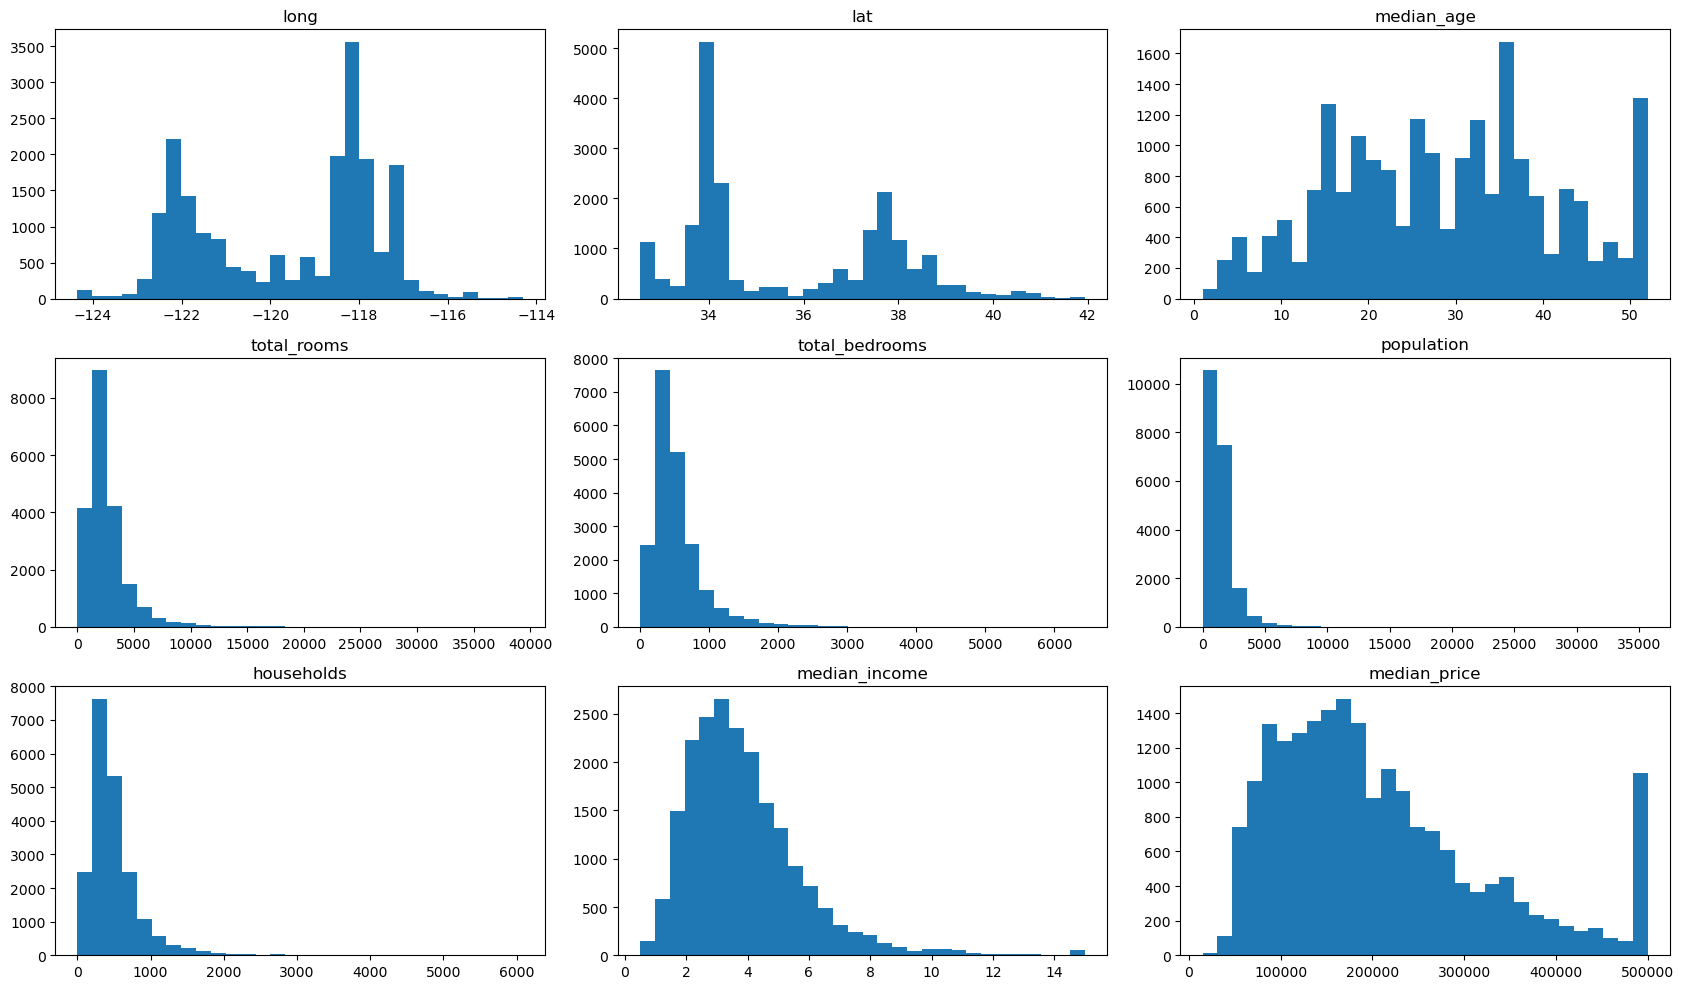

In [21]:
temp_df = df.drop(['<1H_ocean', 'inland', 'island', 'near_bay', 'near_ocean'], axis='columns')
hist = temp_df.hist(bins=30, figsize=(17, 10), grid=False)
plt.tight_layout()
plt.show()

As expected, some variables have distributions that are clearly not normal, such as longitude and latitude, as this is geographical data. Other variables have normal distributions, which is good for our analysis, such as total rooms per neighborhood and median outcome. For variables like median house price and median income, we observe that there are a few extreme outliers on the higher end of the price range. We don't display the variables describing how close the house is to the ocean since these values were one hot encoded. The histograms don't provide us with much information on the one-hot encoded values, hence those columns were dropped for this visualization. 

Instead, we make a barplot to represent the percentage of houses that are less than one hour from the ocean, percentage of houses that are inland, etc. 

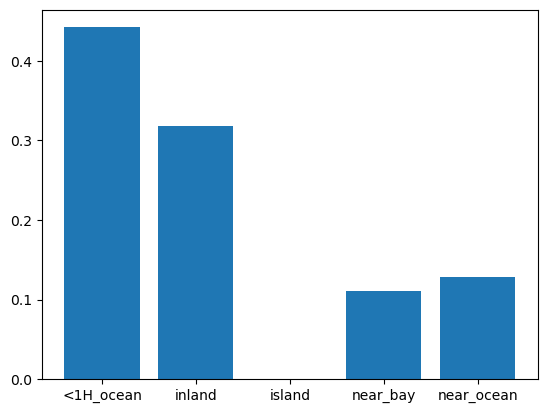

In [22]:
ocean_prox = ['<1H_ocean', 'inland', 'island', 'near_bay', 'near_ocean']
total_obs = float(df[ocean_prox].sum().sum())
categorical = df[ocean_prox].sum().apply(lambda x: x / total_obs) # sum up and make into a percentage
bar = plt.bar(ocean_prox, categorical)

We notice that not all categories are equally represented in our data; for example, there are very few houses that are on islands. Therefore, our models will not have as adequate data for categories with less data.

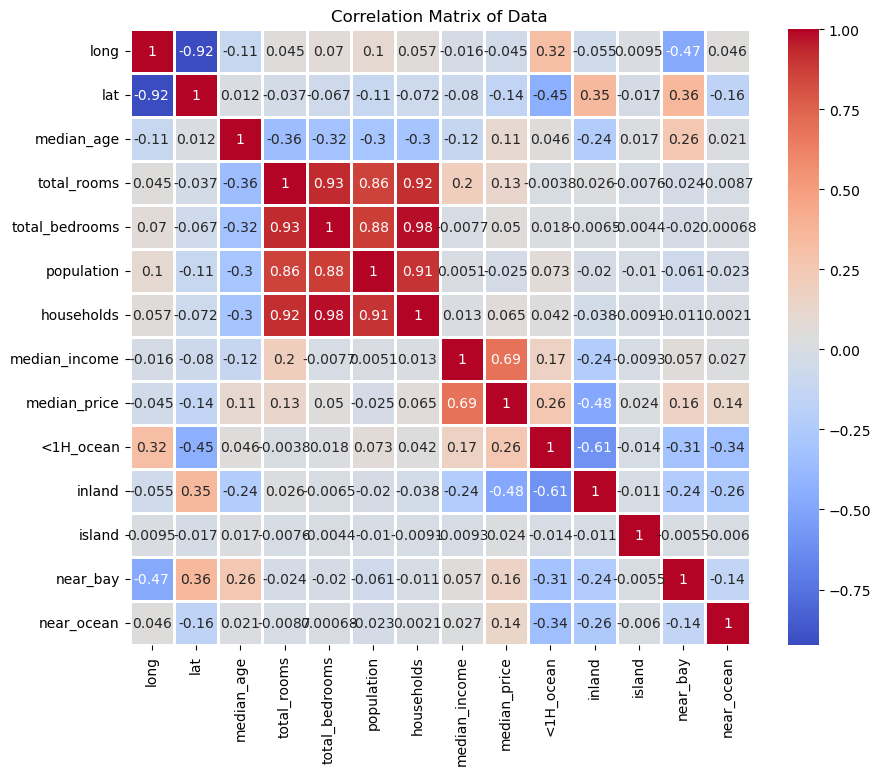

In [23]:
correlation = df.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.8) 
plt.title('Correlation Matrix of Data') 
plt.show() 

Next, we take a look at correlations of variables using a correlation matrix, which shows us the strength of the relationship between all possible pairs of variables. From the graph, we can see that pairs of variables such as total bedrooms/total rooms and median price/median income have a positive correlation, which makes logical sense. 

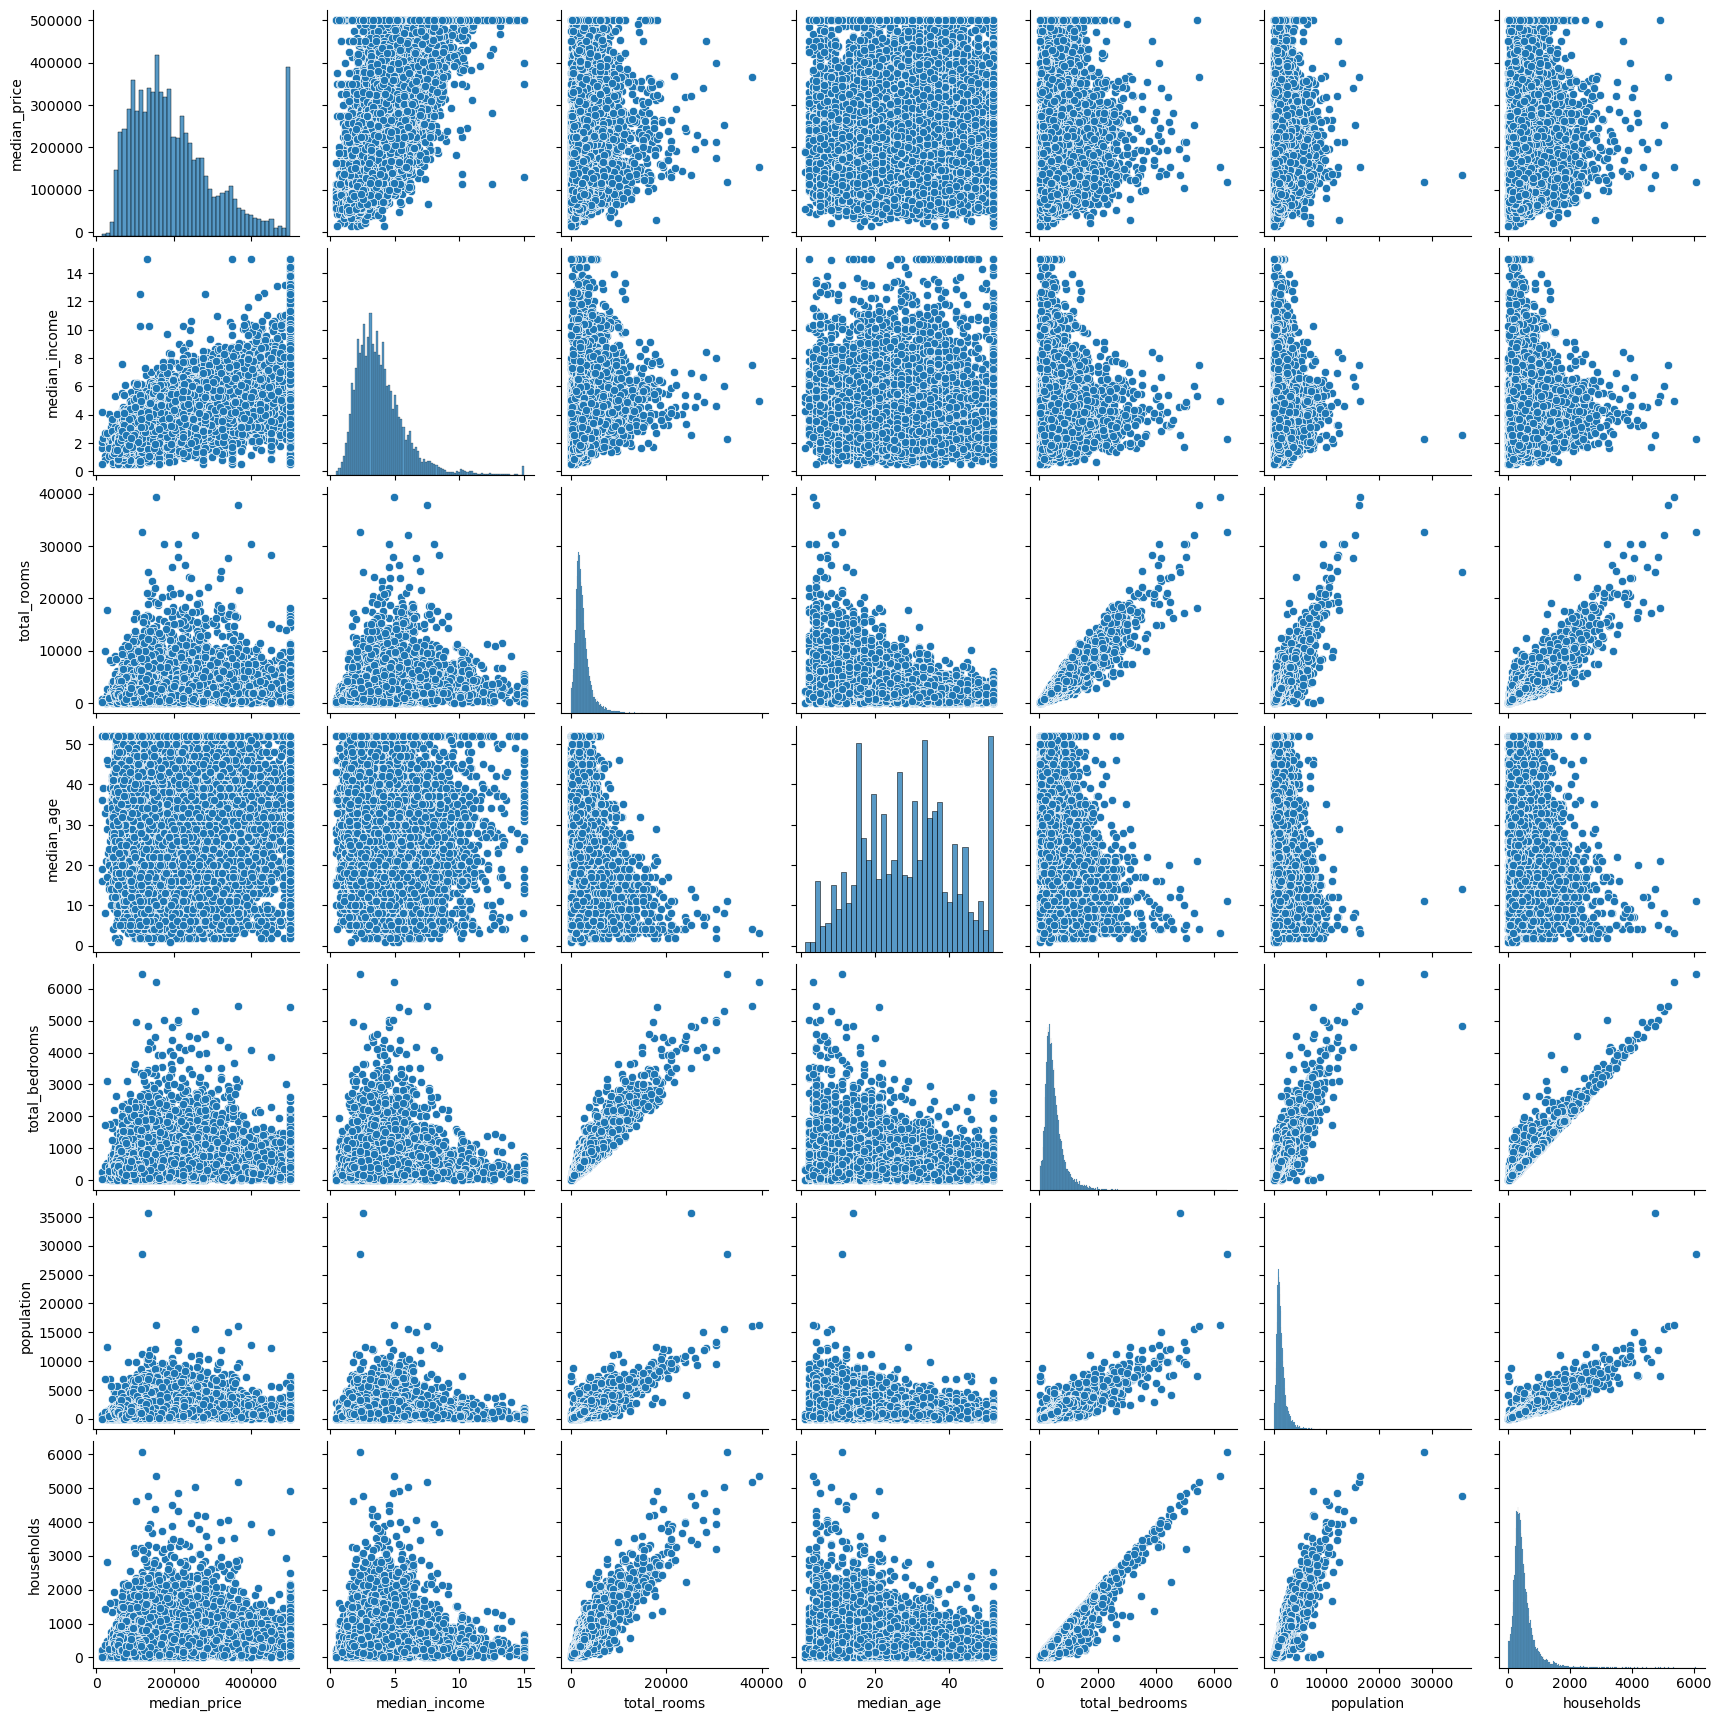

In [24]:
att=["median_price","median_income","total_rooms","median_age","total_bedrooms","population","households"]
scatter = sns.pairplot(df[att])

Lastly, we checkout some scatterplots of a few pairs of variables from the housing data to look at the data and see if there are any noticeable trends. Using this scatter plot matrix, we get similar information that we got from the correlation matrix, with strong correlations between certain variables like total bedrooms/total rooms and median price/median income. These observations are consistent with the trends we have noticed before.

# Proposed Solution

After considering our EDA, one solution to our problem is to consider multiple different models and implement a multivariate regression model because we are utilizing multiple variables, such as proximity to the ocean, total rooms within a block, and number of households within a block, to predict the numerical housing prices for a given neighborhood. 

We will first try a linear model with the form $y_i = \mathbf{w}x_i + b$ and find the optimal weight values analytically because linear regression provides a closed form solution rather than forcing us to go through gradient descent. We will also try ElasticNet regression, which regularizes the weights of the model to prevent overfitting. However, because a linear model assumes some extent of normality and is a parametric method, we want to try some nonparametric models to compare performance.

The second model we plan to try is a k-nearest neighbors model when doing model selection to determine the best model to approach our problem. This will cluster the neighborhoods in our training data into groups based on their similarities to each other. During testing, the kNN model will determine which cluster the test data is most similar to and predict the housing prices based on that. Because we only have ten variables, the dimension of the features is small enough that we won’t have problems with having a too large dimension where all the neighbors are far from each other. However, we will also perform PCA for dimensionality reduction and see if we get better results from our model.

Lastly, we will implement a decision tree model and a random forest model, which splits the data multiple times based on some threshold. 

We will select our algorithm by first selecting the best hyperparameters for each algorithm through cross-validation in combination with grid search, then comparing the results of each algorithm to perform algorithm selection. We will use the Python library sklearn.

# Evaluation Metrics

For our multivariate regression model, we have used MSE, RMSE and R2 error, which are represented by the following formulae:  

\begin{align*}
	MSE &= \sum_{i=1}^{D}(x_i-y_i)^2\\
    RMSE &= \sqrt{\sum_{i=1}^{D}(x_i-y_i)^2}\\
    R^2 &= 1-\frac{\text{sum squared regression (SSR)}}{\text{total sum of squares (SST)}},\\ &=1-\frac{\sum({y_i}-\hat{y_i})^2}{\sum(y_i-\bar{y})^2}\\
\end{align*}

We use R2 as a measure of how much variance the model explains. We also use RMSE and MSE to measure the error between the model's prediction and the actual values. These 3 error metrics combined help us find the best model for making the most accurate predictions. 

# Results

The first step is to the split the dataset into training and test sets. Our dataset has already been cleaned and the categorical features have been one-hot encoded. We define our predictor as all the features from the dataset except median price, which is our response variable that the model needs to predict. We also do some data preprocessing before we train any models by standardizing the data using StandardScalar to prevent any unnecessary skew or biases towards data of higher magnitude. 
The aim of this preprocessing was to standardize all values to a range where we can run different regressions on it successfully.

In [25]:
# given two arrays of the same size, truth and predicted
# prints metrics r2, residual mean squared error, and mean squared error
def print_metrics(truth, predicted):
    mse = mean_squared_error(y_test, predicted)
    return r2_score(truth, predicted), np.sqrt(mse), mse

In [26]:
# set predictors and response variable
X = df.drop('median_price',axis=1) 
y = df['median_price']

# take 33% of data to be in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Standardizing the values
standardizer = StandardScaler() 
X_train = standardizer.fit_transform(X_train)
X_test = standardizer.fit_transform(X_test)

We setup an array to store the error metrics of the different models we run to find the best performing model with this particular dataset. 

In [27]:
# [LinReg, ElasticNet, randomForest, knn, decision trees]
MODEL_NUM = 5
rmse, mse, r2 = np.zeros(MODEL_NUM), np.zeros(MODEL_NUM), np.zeros(MODEL_NUM)

# Linear Regression
We use a basic linear regression model as our base model with this data set to see how well it performs with our error metrics ($r^2$, MSE, RMSE). We don't have to tune any hyperparameters for linear regression.

In [28]:
# linear regression model
linReg = LinearRegression()
linReg.fit(X_train,y_train)
y_pred = linReg.predict(X_test)
mse[3] = mean_squared_error(y_test,y_pred)
r2[3] = r2_score(y_test,y_pred)
rmse[3] = np.sqrt(mean_squared_error(y_test, y_pred))
print_metrics(y_test, y_pred)

(0.6567605945920528, 67462.04821148927, 4551127948.889301)

# ElasticNet Regression
We use an ElasticNet regression model here and measure how well it performed on the dataset with specific error metrics. We conducted hyperparameter tuning using 5-fold Cross Validation. It tuned the hyperparameter values of alpha and l1_ratio for this  model, which represent the amount of regularization and the ratio between L1 and L2 penalty respectively. 

Using grid search, we determined that the best hyperparameters, as printed below. We see this model actually performs significantly worse than the linear regression model, because the $r^2$ is quite low, meaning very little of the variance in the test set is explained. Moreover, the MSE is much higher than the MSE for the linear model. Therefore, we hypothesize the ElasticNet model is overfit. 

In [29]:
# parameters to tune: l1_ratio (how much weight to give to L1 vs. L2 penalty) & 
# alpha (how much weight given to regularization, where 0 means no regularization)
elasticNet = ElasticNetCV(cv=5, random_state=42)
elasticNet.fit(X_train, y_train)

y_predEN = elasticNet.predict(X_test)
print("Alpha: " + str(elasticNet.alpha_))
print("l1_ratio: " + str(elasticNet.l1_ratio_))
mse[4] = mean_squared_error(y_test,y_predEN)
r2[4] = r2_score(y_test,y_predEN)
rmse[4] = np.sqrt(mean_squared_error(y_test, y_predEN))
print_metrics(y_test, y_predEN)

Alpha: 158.41209935798864
l1_ratio: 0.5


(0.02141120790915796, 113909.79515553617, 12975441432.37621)

# Feature-Selection
We conduct feature selection in this section. We try to identify the most relevant features from the dataset and discard irrelevant ones. With this dataset, conducting feature selection can provide several benefits and help improve the performance of predictive models since it helps reduce dimensionality of the data. It also helps reduce overfitting.

We use PCA here for feature selection. The code calculates the explained variance ratio and singular values for each feature in the data. These values help us indicate the importance of each principal component and we can determine which principal components capture the most amount of information.

In [30]:
pca = PCA(n_components = 13)
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[3.01046774e-01 1.97455587e-01 1.27144528e-01 9.65775016e-02
 8.28801458e-02 7.66492421e-02 5.47061486e-02 4.37250928e-02
 1.18628699e-02 4.73721384e-03 2.03810166e-03 1.17679442e-03
 8.43865298e-33]
[2.31467696e+02 1.87459785e+02 1.50425768e+02 1.31102624e+02
 1.21450317e+02 1.16795829e+02 9.86714410e+01 8.82142549e+01
 4.59481769e+01 2.90358734e+01 1.90452344e+01 1.44718383e+01
 3.87534137e-14]


# Cross-Validation

For our model selection, we decided to use cross-validation with grid search. For the random forest, KNN, and decision tree models, we selected a few hyperparameters to tune after reading some literature about hyperparameters that are typically tuned for these models. We selected these hyperparameters based on the negative mean absolute error metric, which isn't as affected by large error values. To get an overall estimate of how these models might generalize after tuning hyperparameters, we printed the $r^2$, MSE, and RMSE metrics.

In [31]:
# Random forest model
# best parameters:{'max_depth': 40, 'max_features': None, 'n_estimators': 500}
randomForest = RandomForestRegressor(random_state = 42)
randForestcv = GridSearchCV(randomForest, 
                           param_grid={'n_estimators': [100, 300, 500], 
                                   'max_features': ['sqrt', 'log2' , None],
                                    'max_depth': [20, 40, None]},
                           scoring='neg_mean_absolute_error',
                           cv=5)
randForestcv = randForestcv.fit(X_train, y_train)
y_predRF = randForestcv.predict(X_test)
print(randForestcv.best_params_)
print_metrics(y_test, y_predRF)

{'max_depth': 40, 'max_features': None, 'n_estimators': 500}


(0.7644169336093909, 55889.85557093643, 3123675955.7401342)

In [32]:
# knn model
# best parameters: {'leaf_size': 1, 'n_neighbors': 11}
knn = KNeighborsRegressor()
knnparams = {'leaf_size': range(1, 50, 5),
            'n_neighbors': range(1, 30, 5)}
knncv = GridSearchCV(knn,
                    param_grid=knnparams,
                     scoring='neg_mean_absolute_error',
                    cv=5)
knncv = knncv.fit(X_train, y_train)
y_predKnn = knncv.predict(X_test)
print(knncv.best_params_) 
print_metrics(y_test, y_predKnn)

{'leaf_size': 1, 'n_neighbors': 11}


(0.7266978852023556, 60198.05345589862, 3623805639.879227)

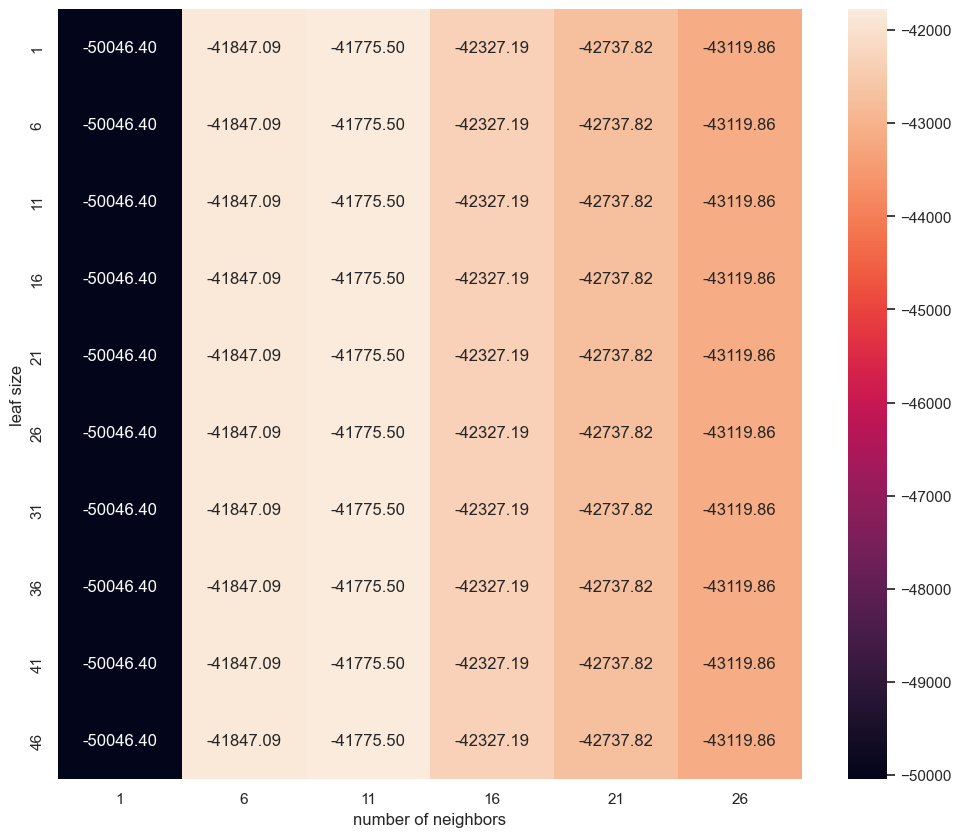

In [35]:
sns.set(rc={'figure.figsize':(12, 10)})
cvresults = knncv.cv_results_
df = pd.DataFrame(cvresults['params'])
df['accuracy'] = cvresults['mean_test_score']
plot = sns.heatmap(df.pivot(index='leaf_size', columns='n_neighbors'), 
                   annot=True, fmt='3.2f', xticklabels=range(1, 30, 5))
plot = plot.set(xlabel="number of neighbors", ylabel="leaf size")

From the heatmap, we can observe that the best hyperparameters are for eleven neighbors and any leaf size. The scale shows the value of the negative mean absolute error which is color coded; larger values of negative mean absolute error mean the model is worse. Therefore, the lighter color means better negative mean absolute error values. 

In [44]:
# decision tree
# best parameters: {'max_depth': None, 'max_features': None, 'min_samples_split': 50}
decisionTree = DecisionTreeRegressor()
dtparams = {'max_depth': [10, 20, 30, 40, 100, None],
            'max_features': ['sqrt', None],
            'min_samples_split': [10, 50, 100]}
decisionTreecv = GridSearchCV(decisionTree, 
                             param_grid=dtparams,
                             scoring='neg_mean_absolute_error',
                             cv=5)
decisionTreecv = decisionTreecv.fit(X_train, y_train)
y_predDt = decisionTreecv.predict(X_test)
print(decisionTreecv.best_params_)
print_metrics(y_test, y_predDt)

{'max_depth': 100, 'max_features': None, 'min_samples_split': 50}


(0.6445419126038233, 68652.30955108095, 4713139606.697441)

Because heatmaps can only display combinations of two different hyperparameters, we plot a different visualization here: validation curves, which illustrate the mean training and validation error averaged across 5 folds of cross-validation for just one hyperparameter. Higher negative mean absolute error means the model performed better. In this report, we show a few examples with some hyperparameters from the KNN and decision tree models. 

In [36]:
# given an estimator which can fit & train data, hyperparameter options, and a hyperparameter, plots a validation graph
def validation_graph(estimator, hyperparams, param):
    train, valid = validation_curve(estimator, X_train, y_train, param_name=param, param_range=hyperparams, cv=5, 
                                    scoring='neg_mean_absolute_error')
    train_mean = np.mean(train, axis=1)
    valid_mean = np.mean(valid, axis=1)
    fig = sns.lineplot(data=pd.DataFrame(data={'train': train_mean, 'valid': valid_mean}, index=hyperparams), markers=True)
    plt.xlabel(param)
    plt.ylabel('Negative Mean Absolute Error')
    return fig

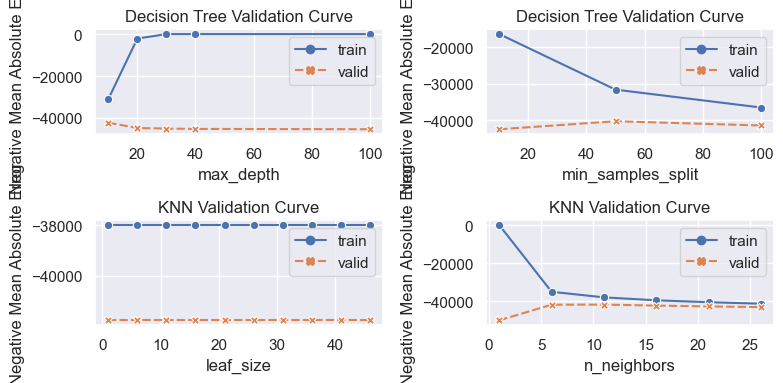

In [43]:

plt.subplot(2, 2, 1)
validation_graph(decisionTree, dtparams['max_depth'], 'max_depth')
plt.title('Decision Tree Validation Curve')

plt.subplot(2, 2, 2)
validation_graph(decisionTree, dtparams['min_samples_split'], 'min_samples_split')
plt.title('Decision Tree Validation Curve')

plt.subplot(2, 2, 3)
validation_graph(knn, knnparams['leaf_size'], 'leaf_size')
plt.title('KNN Validation Curve')

plt.subplot(2, 2, 4)
validation_graph(knn, knnparams['n_neighbors'], 'n_neighbors')
plt.title('KNN Validation Curve')

plt.tight_layout()
plt.show()

Taking a closer look at the validation graphs, we notice that the validation error is always lower than the training error, which makes sense, as the model will always perform better on data that it has seen. One observation we make is that for the decision tree graph with the hyperparameter max depth, it is likely that the model is overfit because training error is 0, meaning the model has probably memorized the training data. The validation curves are helpful because it helps visualize which hyperparameter values maximize validation error. For example, for the KNN graph with the hyperparameter number of neighbors, the best likely hyperparameter is around 5-10 neighbors. Another observation we make is that the graph for KNN, hyperparameter leaf size, shows that changes in the hyperparameter doesn't effect the error. 

# Running the Actual Models with Best Hyperparameters

After running cross validation, we finally rerun the models with the best hyperparameters we found to make a final comparison of the algorithms. To properly visualize our results, we make bargraphs.

In [39]:
randomForest = RandomForestRegressor(n_estimators=500, max_depth=40, max_features=None)
randomForest.fit(X_train, y_train)
y_predRF = randomForest.predict(X_test)
mse[0] = mean_squared_error(y_test,y_predRF)
r2[0] = r2_score(y_test,y_predRF)
rmse[0] = np.sqrt(mean_squared_error(y_test, y_predRF))
print_metrics(y_test, y_predRF)

(0.7647240732319174, 55853.41070233192, 3119603487.083366)

In [40]:
knn = KNeighborsRegressor(leaf_size=1, n_neighbors=11)
knn.fit(X_train, y_train)
y_predKnn = knn.predict(X_test)
mse[1] = mean_squared_error(y_test,y_predKnn)
r2[1] = r2_score(y_test,y_predKnn)
rmse[1] = np.sqrt(mean_squared_error(y_test, y_predKnn))
print_metrics(y_test, y_predKnn)

(0.7266978852023556, 60198.05345589862, 3623805639.879227)

In [41]:
decisionTree = DecisionTreeRegressor(max_depth=100, max_features=None, min_samples_split=50)
decisionTree.fit(X_train, y_train)
y_predDt = decisionTree.predict(X_test)
mse[2] = mean_squared_error(y_test,y_predDt)
r2[2] = r2_score(y_test,y_predDt)
rmse[2] = np.sqrt(mean_squared_error(y_test, y_predDt))
print_metrics(y_test, y_predDt)

(0.6504090187085912, 68083.37280519195, 4635345652.530749)

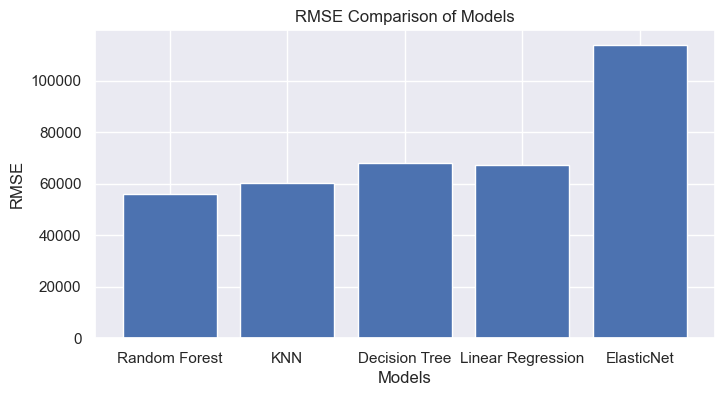

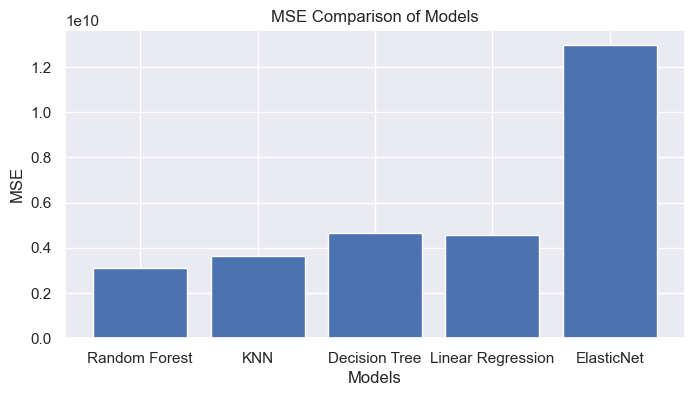

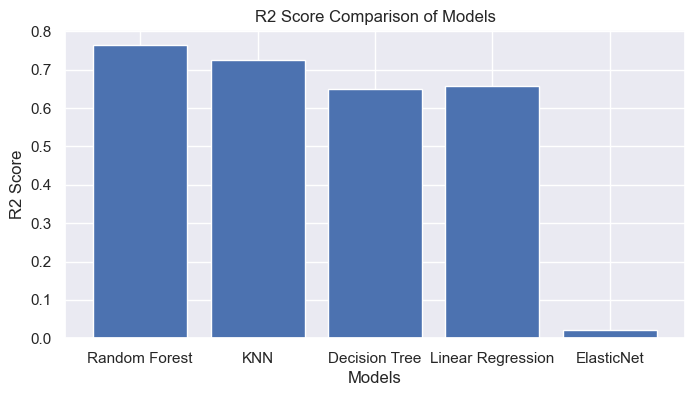

In [42]:
models = ['Random Forest', 'KNN', 'Decision Tree', 'Linear Regression', 'ElasticNet']

plt.rcParams['figure.figsize'] = (8, 4)

plt.bar(models, rmse)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.show()

plt.bar(models, mse)
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE Comparison of Models')
plt.show()

plt.bar(models, r2)
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison of Models')
plt.show()

# Discussion

### Interpreting the result
We used a host of different models to compare for this project because each is particularly suited to a different combination of data, computational efficiency, and complexity. Decision trees and random forests, for example, were selected for not being terribly computationally expensive but providing decent results regardless. Some of our models required more in-depth searches for optimal hyperparameters, which we carried out to the best of our ability. It's important to note, however, that since certain aspects of our search -- the cross-validation, for example -- took so long to run that we didn't have the time or resources to tweak and rerun them as much as we would like. Ultimately we found that for all of the metrics we measured, the Random Forest regression model appeared to be the most successful in terms of minimizing error and making accurate predictions. We also need to consider what we didn't end up doing but potentially should have done. We might have done better to incorporate feature selection into our models, removing some variables with particularly strong correlations so as to continue to optimize for accuracy. We might also have weighted certain features more heavily than others to make up for gaps in the data, or have conducted imputation in the most statistically accurate way possible. As previously mentioned, we might have done better to extensively test many combinations of hyperparameters for our models with very slow training times (such as random forest). 

Overall all the models we implemented had similar performance with respect to the error metrics we have used (other than elasticNet). However we notice that the Random Forest model performs the best with our dataset and would be the model we would use for predicting housing prices in California.  

### Limitations

The data is from 1990. It almost certainly is no longer accurate as a predictor of housing prices in the 2020s simply because of how the geography and economy of the state have changed -- although this project is successful as an exercise, it's not super usable in real life. If we were able to collect or find a matching dataset with more modern data, we could actually use it in a practical way, but this data is the best we could find at this time. 

Another limitation with our implementation was that we used PCA for feature selection but did not have the time to implement it into training our models. We would have liked to implement this to make more accurate predictions and give weightage to features with more importance in the data.

Another concern is, looking at our metrics of evaluation, we may have overfit -- the ElasticNet shows a really low R2 score which implies overfitting on the training data.

### Ethics & Privacy

We understand and are aware that our project should follow certain ethics and data privacy guidelines. The Kaggle dataset we are using pulls from the 1990 US census data, which means a lot of standard concerns about personally identifiable information or informed consent are already taken care of. However, we understand that there might be some ethical implications when we consider other factors that affect housing prices that aren’t included in the dataset — for example the racial makeup of the population. Because the data only looks at limited aspects/variables, there may be bias or factors that we fail to consider in our predictions.

### Conclusion

To conclude, the main objective of our project was to find and implement a multivariate regression model which will help us predict the housing prices for a particular neighbourhood with the help of several factors. 

The main flow of our project was to find a problem statement which actually affects people and then make sure that we have an adequate dataset so that we can find an optimal solution. After that step, we did data analysis in the form of histograms, bar charts, correlation matrices and scatterplots. We learned a lot about data through this. Our next steps were to implement a linear model as well as ElasticNet regression. We further implemented more complex regression models such as k-nearest neighbours which helped us to cluster the data more. We also used decision tree and random forest regressors as potential models for our ML algorithm. We also used cross validation to find the best hyperparameters for the respective regression models and we then trained them with those hyperparameters to get the highest performace.  

By comparing all the error metrics, we noticed that the Random Forest model performs the best and would use this model to predict housing prices in California.

# Extra Credit

We feel that our project addresses a very significant problem that UC San Diego students actually face in their daily life using the certain machine learning models we learnt in this course. We were always on top of our work and everyone of us wanted to make this project a huge success. We made sure to check in with the TAs on a relatively frequent basis to get feedback on our progress and make sure that we didn’t miss anything. Moreover, we used several models along with running Cross Validation for each one of them to get the best hyperparameters for them to find the best combination of a model and its hyperparams to make the most accurate predictions. 

# Footnotes
<a name="huangnote"></a>1.[^](#huang): Huang, Y. (2019). Predicting Home Value in California, United States via Machine Learning Modeling. Statistics, Optimization & Information Computing, 7(1), 66-74. https://doi.org/10.19139/soic.v7i1.435.<br>
<a name="manasanote"></a>2.[^](#manasa): J. Manasa, R. Gupta and N. S. Narahari, "Machine Learning based Predicting House Prices using Regression Techniques," 2020 2nd International Conference on Innovative Mechanisms for Industry Applications (ICIMIA), Bangalore, India, 2020, pp. 624-630, doi: 10.1109/ICIMIA48430.2020.9074952.<br>
<a name="pacenote"></a>3.[^](#pace): Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297. https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.<br>
<a name="nugentnote"></a>4.[^](#nugent): Cam Nugent. 2018. California Housing Prices, Version 1. https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download<br>

